# Notebook to create an overview figure that show TXLA shelf conditions during the student cruise. 
Compare Sentinal 3 chlorophyll and total suspended matter from July 3, 2022 during the student cruise. 
<br>
For definitions, see https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/definitions/units

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

# Open data. File for lat/lon coordinates, chl, and TSM

In [2]:
paths = ['../sat_raw/s3b/geo_coordinates.nc', '../sat_raw/s3b/chl_nn.nc', '../sat_raw/s3b/tsm_nn.nc'] 
dss = xr.open_mfdataset(paths).load()
# dss = dss.where(dss.latitude>25) #cutoff latitude above 25 N
dss

<xarray.Dataset>
Dimensions:     (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    CHL_NN      (rows, columns) float32 nan nan nan nan nan ... nan nan nan nan
    CHL_NN_err  (rows, columns) float32 nan nan nan nan nan ... nan nan nan nan
    TSM_NN      (rows, columns) float32 nan nan nan nan nan ... nan nan nan nan
    TSM_NN_err  (rows, columns) float32 nan nan nan nan nan ... nan nan nan nan
    altitude    (rows, columns) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    latitude    (rows, columns) float64 31.48 31.48 31.48 ... 18.53 18.53 18.53
    longitude   (rows, columns) float64 -100.9 -100.9 -100.9 ... -90.52 -90.52
Attributes: (12/17)
    absolute_orbit_number:  21815
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2022-07-05T05:39:02Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.02
    start_time:             2022-07-03T16:23:56.802797Z
    stop_time:              2022-07-03T16:26:56.726546Z
    title:                  OLCI Level 2 WATER Product, Neural Net Chlorophyl...

In [3]:
paths = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_parent_*.nc')
ds_avg = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_avg, grid_avg = xroms.roms_dataset(ds_avg, Vtransform = 2)

paths = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child_*.nc')
ds_avg_child = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child, Vtransform = 2)

# Misc. functions that could be useful 
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

model_time = str(datetime(2022,7,3,0,0))

rvort = surface_vorticity(ds_avg, grid_avg).sel(ocean_time = model_time)
rvort_child = surface_vorticity(ds_avg_child, grid_avg_child).sel(ocean_time = model_time)

sgradmag = surface_saltgradmag(ds_avg, grid_avg).sel(ocean_time = model_time)
sgradmag_child = surface_saltgradmag(ds_avg_child, grid_avg_child).sel(ocean_time = model_time)

sss_parent = ds_avg.salt.isel(s_rho = -1).sel(ocean_time = model_time)
sss_child = ds_avg_child.salt.isel(s_rho = -1).sel(ocean_time = model_time)

ssh_parent = ds_avg.zeta.sel(ocean_time = model_time)
ssh_child = ds_avg_child.zeta.sel(ocean_time = model_time)

sst_parent = ds_avg.temp.sel(ocean_time = model_time)
sst_child = ds_avg_child.temp.sel(ocean_time = model_time)

# Sort colorbar range of sat. data before making combined figure. Make some test plots 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part ge

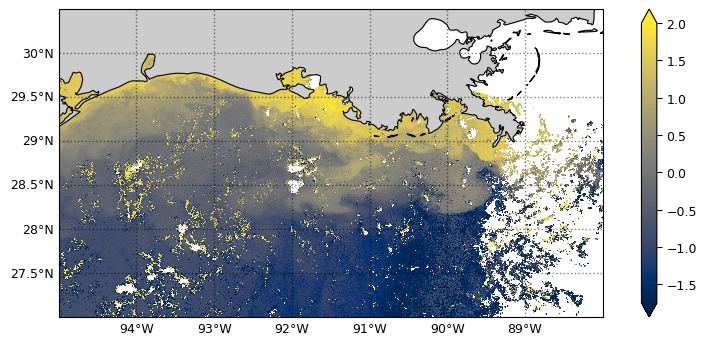

In [4]:
lat_rad = 1.0/np.cos(np.radians(ds_avg.lat_rho.mean().values))

plt.rcParams.update({'font.size': 9})
ncols = 1 ; nrows = 1
crs = ccrs.PlateCarree(central_longitude=-92.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(10,4),dpi = 100, 
                      subplot_kw={'projection': crs}, constrained_layout = False)

mappable = ax.pcolormesh(dss.longitude,
                            dss.latitude,
                            dss.TSM_NN, 
                            cmap = plt.get_cmap('cividis'), vmin = -1.75, vmax = 2,
                            transform = ccrs.PlateCarree())

ax.set_extent([-95, -88, 27, 30.5], crs=ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
# states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect(lat_rad)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

cb = fig.colorbar(mappable, ax = ax, orientation = 'vertical', 
                  extend = 'both')

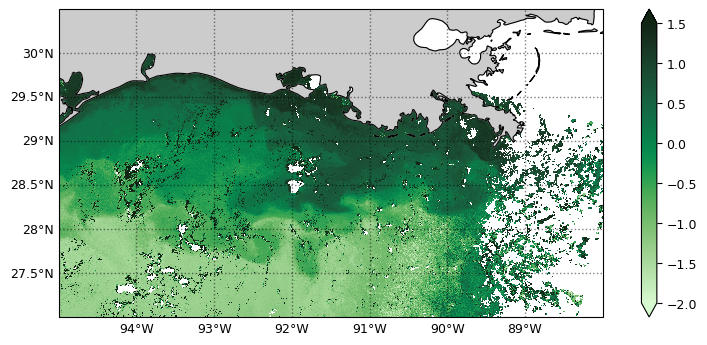

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,4),dpi = 100, 
                      subplot_kw={'projection': crs}, constrained_layout = False)

mappable = ax.pcolormesh(dss.longitude,
                            dss.latitude,
                            dss.CHL_NN, 
                            cmap = cmo.algae, vmin = -2, vmax = 1.5,
                            transform = ccrs.PlateCarree())

ax.set_extent([-95, -88, 27, 30.5], crs=ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
# states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect(lat_rad)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

cb = fig.colorbar(mappable, ax = ax, orientation = 'vertical', 
                  extend = 'both')

# Combine into one subplot. This will take a while, lot of data going into one figure 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/tmp/ipykernel_9844/707256513.py:135: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py

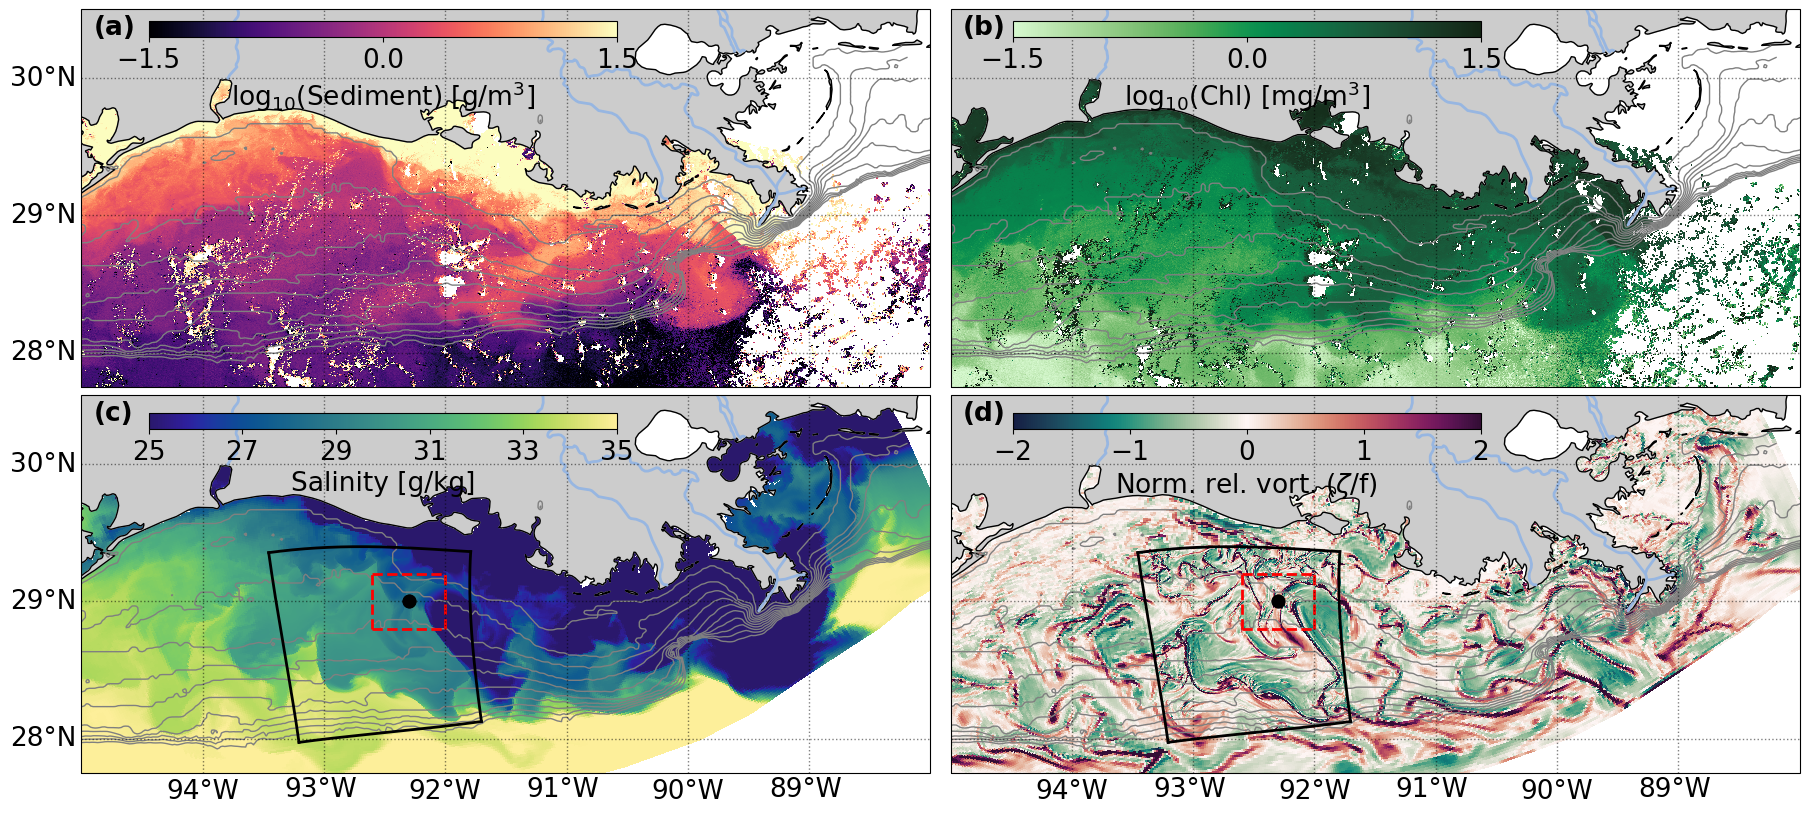

In [27]:
plt.rcParams.update({'font.size': 19})
ncols = 2 ; nrows = 2
crs = ccrs.PlateCarree(central_longitude=-91.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(18,8),
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable1 = ax[0,0].pcolormesh(dss.longitude,
                            dss.latitude,
                            dss.TSM_NN, 
                            cmap = plt.get_cmap('magma'), vmin = -1.5, vmax = 1.5,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.08, 0.96, 0.26, .02])
plt.colorbar(mappable1, cax=cax, orientation='horizontal', ticks = [-1.5,0,1.5]).set_label(r'log$_{10}$(Sediment) [g/m$^{3}$]')

mappable2 = ax[0,1].pcolormesh(dss.longitude,
                               dss.latitude,
                               dss.CHL_NN, 
                            cmap = cmo.algae, vmin = -1.5, vmax = 1.5,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.56, 0.96, 0.26, .02])
plt.colorbar(mappable2, cax=cax, orientation='horizontal',ticks = [-1.5,0,1.5]).set_label(r'log$_{10}$(Chl) [mg/m$^{3}$]')

mappable3 = ax[1,0].pcolormesh(ds_avg.lon_rho,
                            ds_avg.lat_rho,
                            sss_parent, 
                            cmap = cmo.haline, vmin = 25, vmax = 35,
                            transform = ccrs.PlateCarree())

mappable3 = ax[1,0].pcolormesh(ds_avg_child.lon_rho,
                            ds_avg_child.lat_rho,
                            sss_child, 
                            cmap = cmo.haline, vmin = 25, vmax = 35,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.08, 0.47, 0.26, .02])
plt.colorbar(mappable3, cax=cax, orientation='horizontal', ticks = [25,27,29,31,33,35]).set_label(r'Salinity [g/kg]')

mappable4 = ax[1,1].pcolormesh(ds_avg.lon_psi,
                            ds_avg.lat_psi,
                            rvort, 
                            cmap = cmo.curl, vmin = -2, vmax = 2,
                            transform = ccrs.PlateCarree())

mappable5 = ax[1,1].pcolormesh(ds_avg_child.lon_psi,
                            ds_avg_child.lat_psi,
                            rvort_child, 
                            cmap = cmo.curl, vmin = -2, vmax = 2,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.56, 0.47, 0.26, .02])
plt.colorbar(mappable4, cax=cax, orientation='horizontal').set_label(r'Norm. rel. vort. ($\zeta$/f)')

hlevs = [10, 20, 30, 40, 50, 60, 70, 80,90,100] # isobath contour depths
for i in range(2):
    for j in range(2):
        ax[i,j].contour(ds_avg.lon_rho,
                        ds_avg.lat_rho,
                        ds_avg.h, hlevs, colors='grey', 
                        transform=ccrs.PlateCarree(), linewidths=1)
        ax[i,j].set_extent([-95, -88, 27.75, 30.5], crs=ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8', linewidth = 1)
        ax[i,j].coastlines(resolution='10m', linewidth = 1)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].add_feature(cartopy.feature.RIVERS, lw = 2)

gl = ax[0,0].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = False

gl = ax[0,1].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

gl1 = ax[1,0].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=False, crs=ccrs.PlateCarree())
gl1.ylocator = mticker.FixedLocator([28,29,30])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.right_labels = False
gl1.left_labels = True
gl1.top_labels = False
gl1.bottom_labels = True

gl = ax[1,1].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[1,0].plot(ds_avg_child.lon_rho[0,:], ds_avg_child.lat_rho[0,:], 'k', lw=2,transform = cartopy.crs.PlateCarree())
ax[1,0].plot(ds_avg_child.lon_rho[:,0], ds_avg_child.lat_rho[:,0], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,0].plot(ds_avg_child.lon_rho[:,-1], ds_avg_child.lat_rho[:,-1], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,0].plot(ds_avg_child.lon_rho[-1,:], ds_avg_child.lat_rho[-1,:], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)

ax[1,1].plot(ds_avg_child.lon_rho[0,:], ds_avg_child.lat_rho[0,:], 'k', lw=2,transform = cartopy.crs.PlateCarree())
ax[1,1].plot(ds_avg_child.lon_rho[:,0], ds_avg_child.lat_rho[:,0], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,1].plot(ds_avg_child.lon_rho[:,-1], ds_avg_child.lat_rho[:,-1], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,1].plot(ds_avg_child.lon_rho[-1,:], ds_avg_child.lat_rho[-1,:], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)

ax[0,0].text(-94.9,30.32, '(a)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[0,1].text(-94.9,30.32, '(b)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[1,0].text(-94.9,30.32, '(c)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[1,1].text(-94.9,30.32, '(d)',transform=ccrs.PlateCarree(), weight = 'bold')

x=[-92.6,-92.6]
y=[28.8,29.2]
x1=[-92,-92]
y1=[28.8,29.2]
x2=[-92.6,-92]
y2=[28.8,28.8]
x3=[-92.6,-92]
y3=[29.2,29.2]

x4 = [-92.3,-92.3]
y4 = [29,29]

for i in range(2):
    ax[1,i].plot(x,y,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x1,y1,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x2,y2,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x3,y3,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].scatter(x4,y4,transform=ccrs.PlateCarree(), c = 'black', lw = 4)
    
fig.canvas.draw()
# plt.savefig('overview_sat_model.jpg', dpi = 300, bbox_inches='tight', )

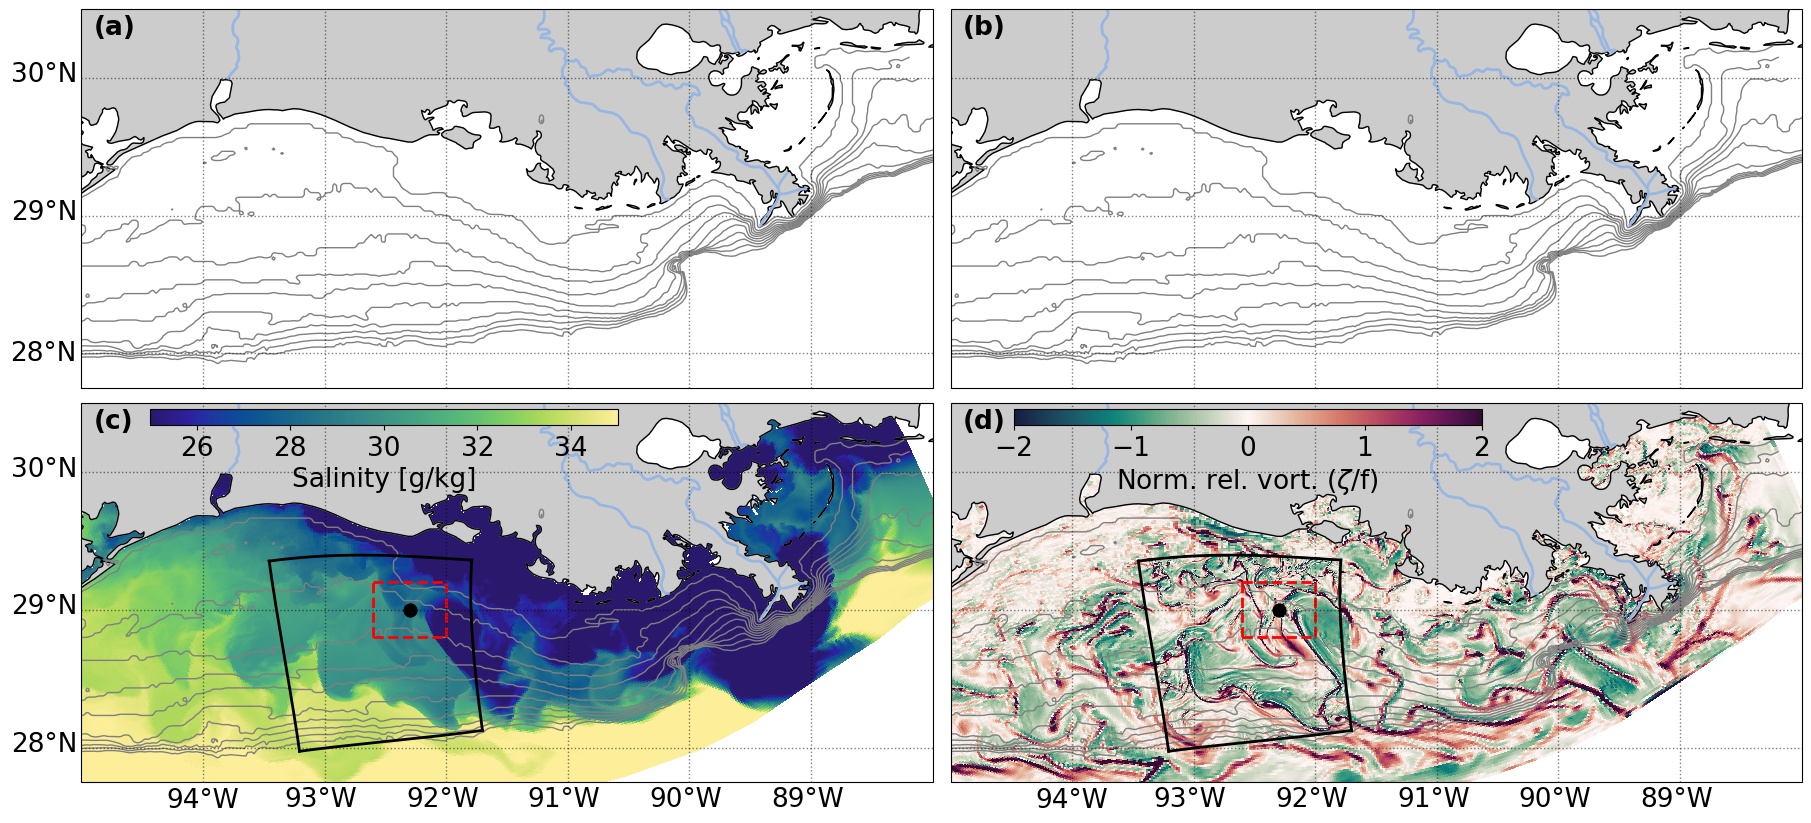

In [8]:
plt.rcParams.update({'font.size': 19})
ncols = 2 ; nrows = 2
crs = ccrs.PlateCarree(central_longitude=-91.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(18,8),
                      subplot_kw={'projection': crs}, constrained_layout = True)

# mappable1 = ax[0,0].pcolormesh(dss.longitude,
#                             dss.latitude,
#                             dss.TSM_NN, 
#                             cmap = plt.get_cmap('magma'), vmin = -1.75, vmax = 2,
#                             transform = ccrs.PlateCarree())

# cax = fig.add_axes([0.08, 0.96, 0.26, .02])
# plt.colorbar(mappable1, cax=cax, orientation='horizontal').set_label(r'log$_{10}$(Sediment) [g/m$^{3}$]')

# mappable2 = ax[0,1].pcolormesh(dss.longitude,
#                                dss.latitude,
#                                dss.CHL_NN, 
#                             cmap = cmo.algae, vmin = -2, vmax = 1.5,
#                             transform = ccrs.PlateCarree())

# cax = fig.add_axes([0.56, 0.96, 0.26, .02])
# plt.colorbar(mappable2, cax=cax, orientation='horizontal').set_label(r'log$_{10}$(Chlorophyll-a) [mg/m$^{3}$]')

mappable3 = ax[1,0].pcolormesh(ds_avg.lon_rho,
                            ds_avg.lat_rho,
                            sss_parent, 
                            cmap = cmo.haline, vmin = 25, vmax = 35,
                            transform = ccrs.PlateCarree())

mappable3 = ax[1,0].pcolormesh(ds_avg_child.lon_rho,
                            ds_avg_child.lat_rho,
                            sss_child, 
                            cmap = cmo.haline, vmin = 25, vmax = 35,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.08, 0.47, 0.26, .02])
plt.colorbar(mappable3, cax=cax, orientation='horizontal').set_label(r'Salinity [g/kg]')

mappable4 = ax[1,1].pcolormesh(ds_avg.lon_psi,
                            ds_avg.lat_psi,
                            rvort, 
                            cmap = cmo.curl, vmin = -2, vmax = 2,
                            transform = ccrs.PlateCarree())

mappable5 = ax[1,1].pcolormesh(ds_avg_child.lon_psi,
                            ds_avg_child.lat_psi,
                            rvort_child, 
                            cmap = cmo.curl, vmin = -2, vmax = 2,
                            transform = ccrs.PlateCarree())

cax = fig.add_axes([0.56, 0.47, 0.26, .02])
plt.colorbar(mappable4, cax=cax, orientation='horizontal').set_label(r'Norm. rel. vort. ($\zeta$/f)')

hlevs = [10, 20, 30, 40, 50, 60, 70, 80,90,100] # isobath contour depths
for i in range(2):
    for j in range(2):
        ax[i,j].contour(ds_avg.lon_rho,
                        ds_avg.lat_rho,
                        ds_avg.h, hlevs, colors='grey', 
                        transform=ccrs.PlateCarree(), linewidths=1)
        ax[i,j].set_extent([-95, -88, 27.75, 30.5], crs=ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8', linewidth = 1)
        ax[i,j].coastlines(resolution='10m', linewidth = 1)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].add_feature(cartopy.feature.RIVERS, lw = 2)

gl = ax[0,0].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = False

gl = ax[0,1].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

gl1 = ax[1,0].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=False, crs=ccrs.PlateCarree())
gl1.ylocator = mticker.FixedLocator([28,29,30])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.right_labels = False
gl1.left_labels = True
gl1.top_labels = False
gl1.bottom_labels = True

gl = ax[1,1].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28,29,30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[1,0].plot(ds_avg_child.lon_rho[0,:], ds_avg_child.lat_rho[0,:], 'k', lw=2,transform = cartopy.crs.PlateCarree())
ax[1,0].plot(ds_avg_child.lon_rho[:,0], ds_avg_child.lat_rho[:,0], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,0].plot(ds_avg_child.lon_rho[:,-1], ds_avg_child.lat_rho[:,-1], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,0].plot(ds_avg_child.lon_rho[-1,:], ds_avg_child.lat_rho[-1,:], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)

ax[1,1].plot(ds_avg_child.lon_rho[0,:], ds_avg_child.lat_rho[0,:], 'k', lw=2,transform = cartopy.crs.PlateCarree())
ax[1,1].plot(ds_avg_child.lon_rho[:,0], ds_avg_child.lat_rho[:,0], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,1].plot(ds_avg_child.lon_rho[:,-1], ds_avg_child.lat_rho[:,-1], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)
ax[1,1].plot(ds_avg_child.lon_rho[-1,:], ds_avg_child.lat_rho[-1,:], 'k', lw=2,transform = cartopy.crs.PlateCarree(),)

ax[0,0].text(-94.9,30.32, '(a)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[0,1].text(-94.9,30.32, '(b)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[1,0].text(-94.9,30.32, '(c)',transform=ccrs.PlateCarree(), weight = 'bold')
ax[1,1].text(-94.9,30.32, '(d)',transform=ccrs.PlateCarree(), weight = 'bold')

x=[-92.6,-92.6]
y=[28.8,29.2]
x1=[-92,-92]
y1=[28.8,29.2]
x2=[-92.6,-92]
y2=[28.8,28.8]
x3=[-92.6,-92]
y3=[29.2,29.2]

x4 = [-92.3,-92.3]
y4 = [29,29]

for i in range(2):
    ax[1,i].plot(x,y,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x1,y1,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x2,y2,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].plot(x3,y3,transform=ccrs.PlateCarree(), ls = '--', c = 'red', lw = 2)
    ax[1,i].scatter(x4,y4,transform=ccrs.PlateCarree(), c = 'black', lw = 4)
    
fig.canvas.draw()
# plt.savefig('overview_sat_model.jpg', dpi = 300, bbox_inches='tight', )

# Let's zoom in to the cruise box for the nested grid 

In [9]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    # ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            # horizontalalignment='center', verticalalignment='bottom')

/tmp/ipykernel_30770/3856689992.py:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


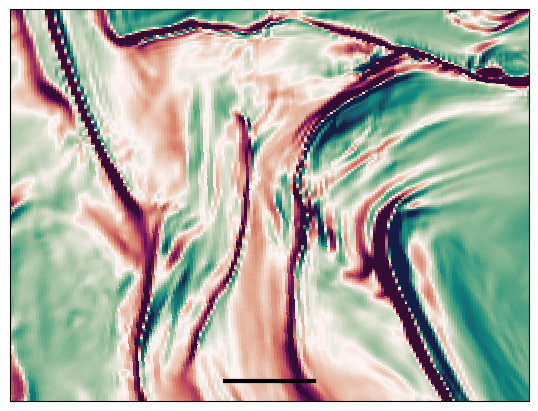

In [10]:
plt.rcParams.update({'font.size': 19})
ncols = 1 ; nrows = 1
crs = ccrs.PlateCarree(central_longitude=-91.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable3 = ax.pcolormesh(ds_avg_child.lon_psi,
                            ds_avg_child.lat_psi,
                            rvort_child, 
                            cmap = cmo.curl, vmin = -2, vmax = 2,
                            transform = ccrs.PlateCarree())


ax.set_extent([-92.6, -92, 28.8,29.2], crs=ccrs.PlateCarree())
# ax.add_feature(land_10m, facecolor='0.8', linewidth = 1)
# ax.coastlines(resolution='10m', linewidth = 1)  
ax.set_aspect(lat_rad)
scale_bar(ax, 10)
    
fig.canvas.draw()
# plt.savefig('vort_zoom.jpg', dpi = 300, bbox_inches='tight', )

/tmp/ipykernel_919/3856689992.py:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


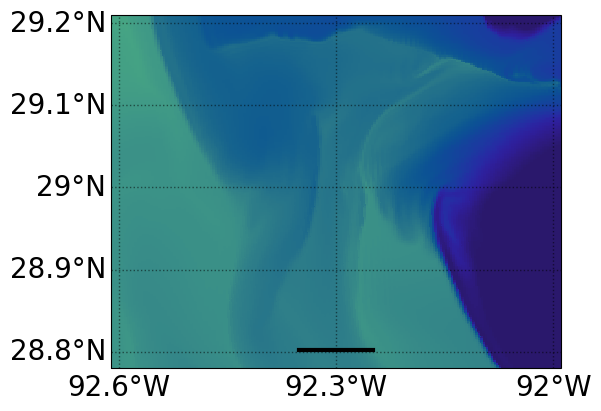

In [24]:
plt.rcParams.update({'font.size': 20})
ncols = 1 ; nrows = 1
crs = ccrs.PlateCarree(central_longitude=-91.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable3 = ax.pcolormesh(ds_avg_child.lon_rho,
                            ds_avg_child.lat_rho,
                            sss_child, 
                            cmap = cmo.haline, vmin = 25, vmax = 35,
                            transform = ccrs.PlateCarree())


ax.set_extent([-92.61, -91.99, 28.78,29.21], crs=ccrs.PlateCarree())
# ax.add_feature(land_10m, facecolor='0.8', linewidth = 1)
# ax.coastlines(resolution='10m', linewidth = 1)  
ax.set_aspect(lat_rad)
# ax.add_feature(cartopy.feature.RIVERS, lw = 2)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28.8,28.9,29,29.1,29.2])
gl.xlocator = mticker.FixedLocator([-92.6,-92.3,-92])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
    
fig.canvas.draw()
scale_bar(ax, 10)
plt.savefig('salt_zoom1.jpg', dpi = 300, bbox_inches='tight', )

# Now plot the sat data zoomed into the same location 

In [26]:
tsm = dss.TSM_NN.load()

/tmp/ipykernel_919/3856689992.py:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


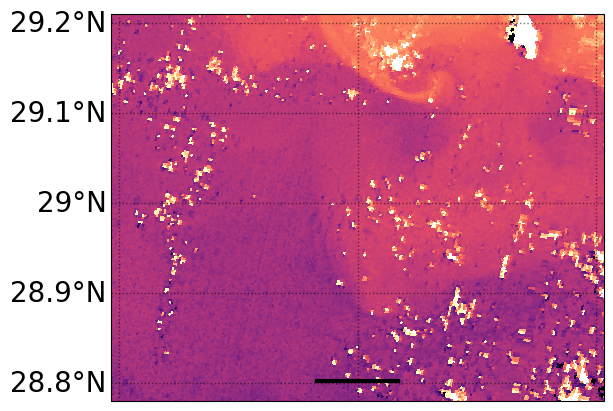

In [27]:
fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable3 = ax.pcolormesh(dss.longitude,
                            dss.latitude,
                            tsm, 
                            cmap = plt.get_cmap('magma'), vmin = -1.5, vmax = 1.5,
                            transform = ccrs.PlateCarree())

ax.set_extent([-92.61, -91.99, 28.78,29.21], crs=ccrs.PlateCarree())
# ax.add_feature(land_10m, facecolor='0.8', linewidth = 1)
# ax.coastlines(resolution='10m', linewidth = 1)  
ax.set_aspect(lat_rad)
# ax.add_feature(cartopy.feature.RIVERS, lw = 2)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28.8,28.9,29,29.1,29.2])
gl.xlocator = mticker.FixedLocator([-92.6,-92.3,-92])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = False

fig.canvas.draw()
scale_bar(ax, 10)

plt.savefig('sat_zoom2.jpg', dpi = 300, bbox_inches='tight', )

In [14]:
su_rho = grid_avg_child.interp(ds_avg_child.sustr, 'X', boundary = 'extend') #boundary = extend is a no gradient condition
sv_rho = grid_avg_child.interp(ds_avg_child.svstr, 'Y', boundary = 'extend')

su_ew = su_rho*np.cos(ds_avg_child.angle)-(sv_rho*np.sin(ds_avg_child.angle)) #East-west
sv_ns = sv_rho*np.cos(ds_avg_child.angle)+(su_rho*np.sin(ds_avg_child.angle)) #North-south

ustr = su_ew.sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00'), ).mean(['eta_rho','xi_rho']).load()
vstr = sv_ns.sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00'), ).mean(['eta_rho','xi_rho']).load()

uwind = ds_avg_child.Uwind.sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00')).mean(['eta_rho','xi_rho']).load()
vwind = ds_avg_child.Vwind.sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00')).mean(['eta_rho','xi_rho']).load()
windspd = np.sqrt(uwind**2+vwind**2)

In [15]:
lon0, lat0 = -92.3, 29
u = ds_avg_child.u.xroms.sel2d(lon0, lat0).sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00')).isel(s_rho=-1).load()
v = ds_avg_child.v.xroms.sel2d(lon0, lat0).sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00')).isel(s_rho=-1).load()

time = ds_avg_child.ocean_time.sel(ocean_time = slice('2022-07-02 18:00','2022-07-05 04:00'))

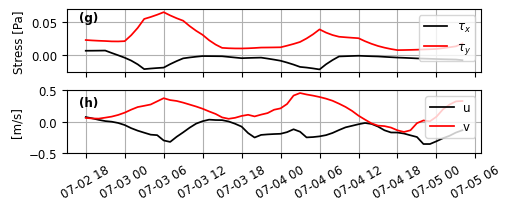

In [16]:
plt.rcParams.update({'font.size': 8.5})
from pandas import Timestamp

fig,ax = plt.subplots(2,1,figsize=(5,2), constrained_layout = True)

ax[0].plot(time,ustr, c = 'k', lw = 1.25, label = r'$\tau_x$')
ax[0].plot(time,vstr, c = 'r', lw = 1.25, label = r'$\tau_y$')
ax[1].plot(time,u, c = 'k', lw = 1.25, label = 'u')
ax[1].plot(time,v, c = 'r', lw = 1.25, label = 'v')

# ax1 = ax[0].twinx()
# ax1.plot(time, windspd, c = 'gray',lw = 1)
# ax1.set_ylabel('Speed [m/s]',color='gray')
# ax1.tick_params(axis='y', labelcolor='gray')
# ax1.set_ylim(2,7)
# ax[0].set_ylim(-0.025, 0.075)

# ax[0].set_title(r'$\bf{(e)}$ Surface wind forcing')
ax[1].set_ylim(-0.5,0.5)
# ax[1].set_title(r'$\bf{(f)}$ Surface currents')
ax[0].set_xticklabels('')
ax[0].set_ylabel('Stress [Pa]')
ax[1].set_ylabel('[m/s]')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc = 'upper right')
ax[i].tick_params(axis='x',labelrotation=30)
ax[0].text(Timestamp("2022-07-02 17:00:00"), 0.0525, "(g)",fontweight="bold")
ax[1].text(Timestamp("2022-07-02 17:00:00"), 0.25, "(h)",fontweight="bold")
plt.savefig('overview_surface_ts_alt.jpg',bbox_inches='tight', dpi = 300)

# Now try to plot the ship tracks on top of the sat. data

In [31]:
ds1 = xr.open_dataset('SUNRISE2022_PE_ShipDas_Processed.nc')
_, index = np.unique(ds1['t'], return_index=True)
ds1 = ds1.isel(t=index)

lon = ds1.lon.sel(t=slice('2022-07-02 18:00','2022-07-05 4:00'))
lat = ds1.lat.sel(t=slice('2022-07-02 18:00','2022-07-05 4:00'))

ds2 = xr.open_dataset('SUNRISE2022_PS_ShipDas_Processed.nc')
_, index = np.unique(ds2['t'], return_index=True)
ds2 = ds2.isel(t=index)

lon2 = ds2.lon.sel(t=slice('2022-07-03 00:00','2022-07-05 2:00'))
lat2 = ds2.lat.sel(t=slice('2022-07-03 00:00','2022-07-05 2:00'))

/tmp/ipykernel_919/3856689992.py:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


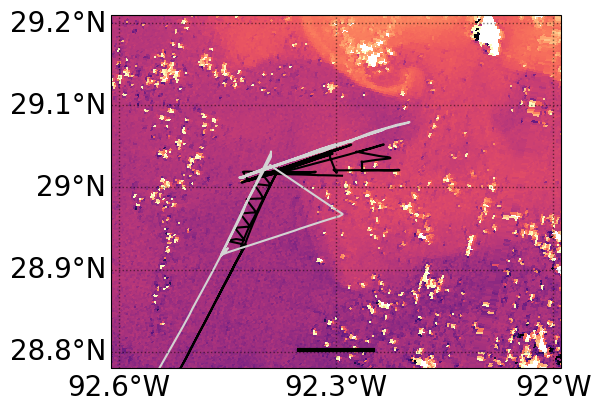

In [34]:
fig,ax = plt.subplots(nrows,ncols,figsize=(18/2,8/2),
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable3 = ax.pcolormesh(dss.longitude,
                            dss.latitude,
                            tsm, 
                            cmap = plt.get_cmap('magma'), vmin = -1.5, vmax = 1.5,
                            transform = ccrs.PlateCarree())
ax.plot(lon[::5],lat[::5],c='k',transform = ccrs.PlateCarree())
ax.plot(lon2[::5],lat2[::5],c='lightgray',transform = ccrs.PlateCarree())
ax.set_extent([-92.61, -91.99, 28.78,29.21], crs=ccrs.PlateCarree())
# ax.add_feature(land_10m, facecolor='0.8', linewidth = 1)
# ax.coastlines(resolution='10m', linewidth = 1)  
ax.set_aspect(lat_rad)
# ax.add_feature(cartopy.feature.RIVERS, lw = 2)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.ylocator = mticker.FixedLocator([28.8,28.9,29,29.1,29.2])
gl.xlocator = mticker.FixedLocator([-92.6,-92.3,-92])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
    
fig.canvas.draw()
scale_bar(ax, 10)
plt.savefig('sat_zoom2.jpg', dpi = 300, bbox_inches='tight', )

# Now look at convergence / divergence over the broader cruise location 

In [14]:
ds = ds_avg_child

In [15]:
# Box for the location of the cruise
lon = np.array([-92.6,-92])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()
tslice = slice('2022-07-03','2022-07-05 12:00')

# From NOAA distance calculator, the N/S boundaries are 58 km long, E/W are 44 km long from ranges used to compute box.
https://www.nhc.noaa.gov/gccalc.shtml

In [30]:
u = ds.u.isel(s_rho=-1)
v = ds.v.isel(s_rho=-1)

dudx = grid_avg_child.derivative(u,'X', boundary = 'extend')
dudx = xroms.to_rho(dudx,grid_avg_child)
dvdy = grid_avg_child.derivative(v,'Y', boundary = 'extend')
dvdy = xroms.to_rho(dvdy,grid_avg_child)

div = (dudx+dvdy)/ds.f
div = div.where(box).sel(ocean_time=tslice).load()

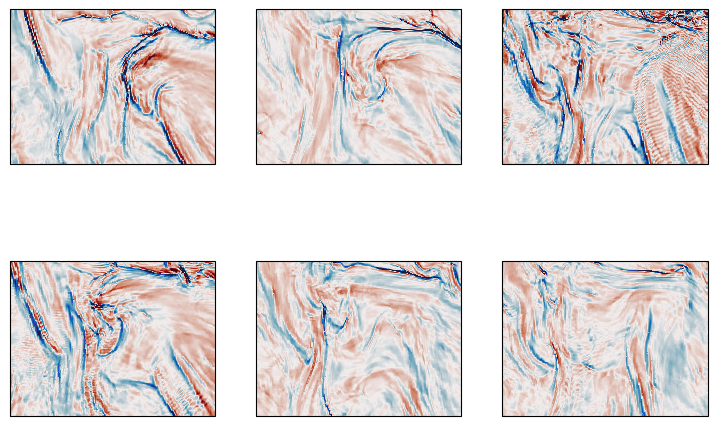

In [45]:
plt.rcParams.update({'font.size': 19})
ncols = 3 ; nrows = 2
crs = ccrs.PlateCarree(central_longitude=-91.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(9,6),
                      subplot_kw={'projection': crs}, constrained_layout = False)

ax[0,0].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[0], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

ax[0,1].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[12], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

ax[1,0].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[24], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

ax[1,1].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[36], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

ax[0,2].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[48], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

ax[1,2].pcolormesh(ds_avg_child.lon_rho,
                   ds_avg_child.lat_rho,
                      div[60], 
                      cmap = cmo.balance, vmin = -3, vmax = 3,
                      transform = ccrs.PlateCarree())

for j in range(3):
    for i in range(2):
        ax[i,j].set_extent([-92.6, -92, 28.8,29.2], crs=ccrs.PlateCarree())
        ax[i,j].set_aspect(lat_rad)
    
fig.canvas.draw()